In [1]:
import glob
import os
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
# data/result/に格納されている全csvファイルの読み込み
csv_files = glob.glob(os.path.join("../../data/result", "*.csv"))
df_list = []
for file in csv_files:
    tmp_df = pd.read_csv(file)
    df_list.append(tmp_df)
df = pd.concat(df_list, ignore_index=True)

In [3]:
# predの要素で, propertyが含まれる値を返す
df_prop = df.query('pred.str.contains("property")', engine='python').dropna()

# 'wikiPage'を含まないpropertyを返す
df_prop = df_prop[~df_prop['pred'].str.contains('wikiPage')]
# '画像'を含まないpropertyを返す
df_prop = df_prop[~df_prop['pred'].str.contains('画像')]

# predの頻出上位10の要素のindex_listを取得
top_10_df_prop = df_prop.groupby('pred').count().sort_values(['obj'], ascending=False).head(10)
top_10_prop_list = top_10_df_prop.index.to_list()

# 頻出上位10を持つdataの抽出
top_10_df = df[df['pred'].isin(top_10_prop_list)]

# predを目的変数(label)として扱うための準備
prop_to_label = dict(zip(top_10_prop_list, range(0,10)))
column_name = dict(map(lambda k: (k[1],k[0].split("/")[-1]), prop_to_label.items()))

In [4]:
# モデル読み込み
model = Word2Vec.load('../../Models/japanese-word2vec-model-builder/word2vec.gensim.model')

In [5]:
# モデルを利用した文字のエンべディング
## 未知語に関しては, 今回はNaNで対応
def vectorize(model, word):
    try:
        output = model.wv[word]
        return output
    except:
        return np.nan

In [6]:
# obj要素に関してはLOD同士が繋がっているため, 基本的にURIで記述されている.
# また, (県の魚:〇〇)の要素や数値データが入っている場合もあるため, それぞれ最後尾の要素を値として扱う. 
def preprocessing(obj):
    if type(obj) != str:
        output = obj
    elif len(obj.split("：")) != 1:
        output = obj.split("：")[-1]
    else:
        output = obj.split("/")[-1]
    return output

In [7]:
# vectorization
## key要素(本データでは〇〇県)は,単純エンベディング対象.
## obj要素は, 上記の関数で整えた後に, エンベディング.
cp_top_10_df = top_10_df.copy()
cp_top_10_df['key_vec'] = cp_top_10_df['key'].map(lambda x:vectorize(model,x))
cp_top_10_df['label'] = cp_top_10_df['pred'].map(prop_to_label)
obj_list = cp_top_10_df['obj'].map(lambda x:preprocessing(x))
cp_top_10_df['obj_vec'] = obj_list.map(lambda x:vectorize(model,x))

In [8]:
# ベクトル化前のデータとベクトル化後のデータの結合 + 未知語のNaNの排除
top_10_df_vec = pd.merge(top_10_df,cp_top_10_df, left_index=True, right_on=top_10_df.index)
top_10_df_vec = top_10_df_vec.reset_index(drop=True)
top_10_df_vec = top_10_df_vec.drop(["key_0","key_y","pred_y","obj_y"], axis=1)
top_10_df_vec = top_10_df_vec.dropna().reset_index(drop=True)

In [48]:
# 目的変数のバイナライズ + 説明変数の切り出し
lb = LabelBinarizer()
lb.fit(top_10_df_vec.label)
label_dence = lb.fit_transform(top_10_df_vec.label)
input_data = list(top_10_df_vec['obj_vec'].values)
#X_train, X_test, y_train, y_test = train_test_split(input_data, label_dence)

In [10]:
# マルチラベル分類
forest = RandomForestClassifier(n_estimators = 500, random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(input_data, label_dence)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                       random_state=1),
                      n_jobs=-1)

In [11]:
estimator = multi_target_forest.estimators_
y_pred = multi_target_forest.predict(input_data)
y_pred_proba = multi_target_forest.predict_proba(input_data)

In [12]:
accuracy_score(label_dence, y_pred)

0.9796954314720813

In [27]:
np_pred = np.array(y_pred)
np_proba = np.array(y_pred_proba)
np_proba_trans = np_proba.transpose(1,0,2)

In [28]:
# ラベル有の閾値の設定
pred_0 = (np_proba_trans[:,:,1] > 0.0).astype(int)
pred_1 = (np_proba_trans[:,:,1] > 0.1).astype(int)
pred_2 = (np_proba_trans[:,:,1] > 0.2).astype(int)
pred_3 = (np_proba_trans[:,:,1] > 0.3).astype(int)

In [29]:
df = pd.DataFrame(np_pred)
df_0 = pd.DataFrame(pred_0)
df_1 = pd.DataFrame(pred_1)
df_2 = pd.DataFrame(pred_2)
df_3 = pd.DataFrame(pred_3)

df_1_new = df_1.rename(columns=column_name)
df_2_new = df_2.rename(columns=column_name)
df_3_new = df_3.rename(columns=column_name)

In [30]:
df_2_new

,隣接都道府県,before,歌など,所在地,説明,表記,years,after,シンボル名,title
0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
586,0,0,0,0,0,1,0,0,0,0
587,0,0,1,0,0,0,0,0,0,0
588,1,0,0,0,0,0,0,0,0,0
589,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'hoge'}>

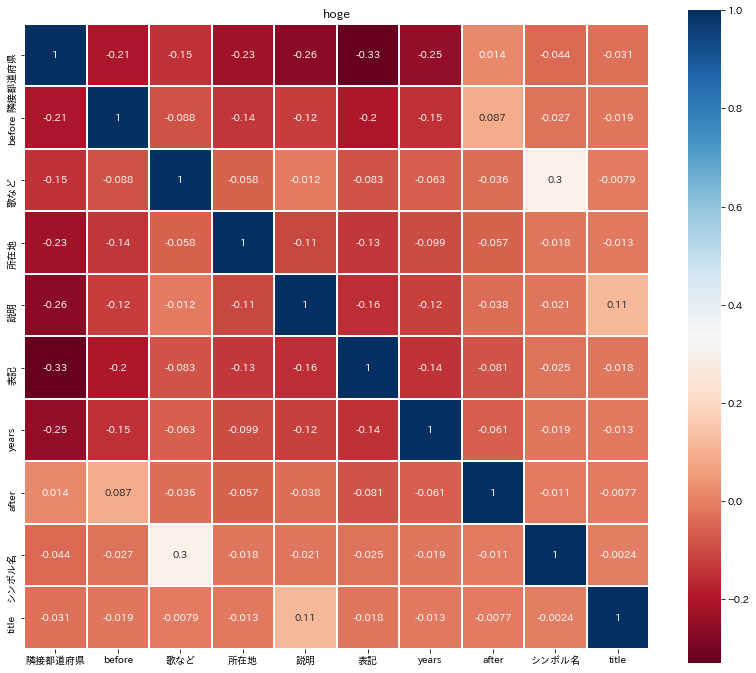

In [31]:
# 相関系の考察

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('hoge')
sns.heatmap(df_2_new.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [32]:
# 要素数の頻度
# Value_count の出力方法をライブラリ見る. 
    ## indexでラベル表示を確認すると, 0が隠れているのが見えた。

# df_3.value_counts().index

In [33]:
df_pre_obj = top_10_df_vec.loc[:,['pred_x','obj_x']]
df_1_pre_obj = pd.concat([df_pre_obj,df_1_new],axis=1)
df_2_pre_obj = pd.concat([df_pre_obj,df_2_new],axis=1)
df_3_pre_obj = pd.concat([df_pre_obj,df_3_new],axis=1)

In [40]:
# df_2_pre_obj[df_2_pre_obj['シンボル名'] == 1]

In [37]:
# df_2_pre_obj[df_2_pre_obj['歌など'] == 1]

In [38]:
# df_2_pre_obj[df_2_pre_obj['説明'] == 1]

In [39]:
# df_2_pre_obj[df_2_pre_obj['title'] == 1]

In [41]:
# 共起系の考察
# pd.crosstab(df_2_pre_obj['歌など'], df_2_pre_obj['シンボル名'])

In [42]:
# pd.crosstab(df_2_pre_obj['説明'], df_2_pre_obj['title'])

In [ ]:
# 教師データと分類結果の比較.
## 未知データを分類したきの相関.

## Randomforestのドキュメントあkら(シングル or マルチのタスクを調べる)

- *多クラス分類とは*
    - 2つ以上のクラス()

In [62]:
# 教師データと分類結果の比較
y_pred_df = pd.DataFrame({'pred': lb.inverse_transform(y_pred)})
top_10_df_vec_pred = pd.concat([top_10_df_vec,y_pred_df],axis=1)

In [67]:
fail_pred_df = top_10_df_vec_pred[top_10_df_vec_pred['label'] != top_10_df_vec_pred['pred']]

In [68]:
fail_pred_df

,key_x,pred_x,obj_x,key_vec,label,obj_vec,pred
13,佐賀県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/長崎県,"[0.07099846, 0.12268844, 0.072164424, 0.127799...",7,"[0.052788623, 0.0894067, 0.10033943, 0.1647479...",0
22,徳島県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/高知県,"[0.013457059, 0.049274415, 0.034320407, 0.1147...",1,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0
80,群馬県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/栃木県,"[0.0038121487, 0.17120449, 0.07788775, 0.14284...",1,"[-0.013253759, 0.1410067, 0.023382558, 0.14527...",0
124,栃木県,http://ja.dbpedia.org/property/歌など,県民の歌：県民の歌,"[-0.013253759, 0.1410067, 0.023382558, 0.14527...",2,"[0.008076205, -0.13247956, -0.10697888, -0.023...",0
199,千葉県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/埼玉県,"[0.05512616, 0.0767111, 0.03694343, 0.08329785...",7,"[0.09730046, 0.06889467, 0.03343996, 0.0733983...",0
254,福井県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/滋賀県,"[0.001963931, 0.19241545, -0.016574373, 0.0958...",1,"[-0.02888879, 0.10544432, -0.039090864, 0.0341...",0
255,福井県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/石川県,"[0.001963931, 0.19241545, -0.016574373, 0.0958...",1,"[-0.031856198, 0.120232046, 0.12296562, 0.0831...",0
338,宮崎県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/鹿児島県,"[0.055857755, 0.109123334, 0.09236161, 0.15419...",7,"[-0.025638053, 0.111953475, 0.030292727, 0.164...",0
352,富山県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/石川県,"[-0.0063511357, 0.13320358, 0.06124245, 0.1111...",1,"[-0.031856198, 0.120232046, 0.12296562, 0.0831...",0
408,香川県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/名東県,"[0.042028457, 0.1020993, 0.15036805, 0.1363238...",7,"[-0.103519194, 0.0015873616, 0.18089372, 0.015...",1


In [60]:
top_10_df_vec

,key_x,pred_x,obj_x,key_vec,label,obj_vec
0,沖縄県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/琉球列島米国軍政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",7,"[-0.13429342, -0.09761905, 0.068803005, 0.0482..."
1,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球列島米国民政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.08374447, 0.07326782, -0.10170767, 0.10177..."
2,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.050090242, 0.18710567, -0.044265315, 0.181..."
3,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球藩,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.20956942, -0.06843233, -0.041769836, -0.07..."
4,沖縄県,http://ja.dbpedia.org/property/years,1879,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",6,"[-0.10014486, 0.016131686, -0.15636334, 0.0958..."
...,...,...,...,...,...,...
586,高知県,http://ja.dbpedia.org/property/表記,次,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",5,"[-0.12088986, 0.10902696, -0.06065345, 0.07214..."
587,高知県,http://ja.dbpedia.org/property/歌など,県の魚：カツオ,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",2,"[-0.1669918, 0.011190996, 0.08135691, 0.178282..."
588,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/大分県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.01619406, 0.14829713, 0.05118972, 0.1368117..."
589,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/徳島県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.013457059, 0.049274415, 0.034320407, 0.1147..."


In [60]:
top_10_df_vec

,key_x,pred_x,obj_x,key_vec,label,obj_vec
0,沖縄県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/琉球列島米国軍政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",7,"[-0.13429342, -0.09761905, 0.068803005, 0.0482..."
1,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球列島米国民政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.08374447, 0.07326782, -0.10170767, 0.10177..."
2,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.050090242, 0.18710567, -0.044265315, 0.181..."
3,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球藩,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.20956942, -0.06843233, -0.041769836, -0.07..."
4,沖縄県,http://ja.dbpedia.org/property/years,1879,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",6,"[-0.10014486, 0.016131686, -0.15636334, 0.0958..."
...,...,...,...,...,...,...
586,高知県,http://ja.dbpedia.org/property/表記,次,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",5,"[-0.12088986, 0.10902696, -0.06065345, 0.07214..."
587,高知県,http://ja.dbpedia.org/property/歌など,県の魚：カツオ,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",2,"[-0.1669918, 0.011190996, 0.08135691, 0.178282..."
588,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/大分県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.01619406, 0.14829713, 0.05118972, 0.1368117..."
589,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/徳島県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.013457059, 0.049274415, 0.034320407, 0.1147..."


In [60]:
top_10_df_vec

,key_x,pred_x,obj_x,key_vec,label,obj_vec
0,沖縄県,http://ja.dbpedia.org/property/after,http://ja.dbpedia.org/resource/琉球列島米国軍政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",7,"[-0.13429342, -0.09761905, 0.068803005, 0.0482..."
1,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球列島米国民政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.08374447, 0.07326782, -0.10170767, 0.10177..."
2,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球政府,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.050090242, 0.18710567, -0.044265315, 0.181..."
3,沖縄県,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/琉球藩,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",1,"[-0.20956942, -0.06843233, -0.041769836, -0.07..."
4,沖縄県,http://ja.dbpedia.org/property/years,1879,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",6,"[-0.10014486, 0.016131686, -0.15636334, 0.0958..."
...,...,...,...,...,...,...
586,高知県,http://ja.dbpedia.org/property/表記,次,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",5,"[-0.12088986, 0.10902696, -0.06065345, 0.07214..."
587,高知県,http://ja.dbpedia.org/property/歌など,県の魚：カツオ,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",2,"[-0.1669918, 0.011190996, 0.08135691, 0.178282..."
588,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/大分県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.01619406, 0.14829713, 0.05118972, 0.1368117..."
589,高知県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/徳島県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",0,"[0.013457059, 0.049274415, 0.034320407, 0.1147..."
